In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import plotly.express as px
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from my_functions import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier

In [82]:
df_prep = pd.read_csv("..\chapter3\gasometry_prepared_data.csv")
cols=["BETET",	"CO2TET",	"HCO3ACTE",	"HCO3STTE",	"O2SATTET",	"O2TET", "IONH"]
my_blue="#0064B2";
my_red="#D61600";

In [83]:
cols2=["BETET",	"CO2TET",	"O2TET", "IONH"]

In [85]:
df_miernik=df_prep[cols2]
vars1=["BETET", "O2TET"]
vars2=["IONH", "CO2TET"]

#wyliczenie wartości poza normą świadczące o zakwaszeniu organizmu
df_miernik[["BETET_neg", "O2TET_neg"]]=df_miernik[vars1].applymap(lambda x: 0 if x >= 0 else abs(x))
df_miernik[["IONH_neg", "CO2TET_neg"]]=df_miernik[vars2].applymap(lambda x: 0 if x <= 1 else x-1)
#wszystkie odchylenia od normy
df_miernik[["BETET_all", "O2TET_all"]] = df_miernik[vars1].applymap(lambda x: 0 if (x >= 0) and (x <= 1) else (abs(x) if x < 0 else x - 1))
df_miernik[["IONH_all", "CO2TET_all"]] = df_miernik[vars2].applymap(lambda x: 0 if (x >= 0) and (x <= 1) else (abs(x) if x < 0 else x - 1))

C:\Users\dorot\AppData\Local\Temp\ipykernel_52004\447075210.py:6: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.

C:\Users\dorot\AppData\Local\Temp\ipykernel_52004\447075210.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\dorot\AppData\Local\Temp\ipykernel_52004\447075210.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\dorot\AppData\Local\Temp\ipykernel_52004\447075210.py:7: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.ma

In [88]:
col_neg=["BETET_neg", "O2TET_neg", "CO2TET_neg", "IONH_neg"]
col_all=["BETET_all", "O2TET_all", "IONH_all", "CO2TET_all"]

df_miernik_df=pd.concat([df_miernik, df_prep[["PACJENT_NR", "BADANIE_NR", "ZGON"]]], axis=1)     
df_miernik_df['Miernik neg_sum'] = df_miernik[col_neg].sum(axis=1)
df_miernik_df["Miernik neg_sum skum."]=df_miernik_df.groupby('PACJENT_NR')['Miernik neg_sum'].cumsum()

df_miernik_df['Miernik all_sum'] = df_miernik[col_all].sum(axis=1)
df_miernik_df["Miernik all_sum skum."]=df_miernik_df.groupby('PACJENT_NR')['Miernik all_sum'].cumsum()
df_miernik_df.to_excel("miernik_skum.xlsx")

### Klasyfikacja na podstawie ostatniej skumulowanej wartości miernika

In [50]:
df_miernik_last = df_miernik_df.groupby('PACJENT_NR').last()
df_miernik_last["PACJENT_NR"]=df_miernik_last.index
df_miernik_last=df_miernik_last.reset_index(drop=True)
mierniki=["Miernik neg_sum skum.", "Miernik all_sum skum."]
df_mierniki_sum_klas=df_miernik_last[[*mierniki, "ZGON"]]
odsetek=0.2

#### Miernik zliczający odchylenia świadczące o kwasicy

Dokładność klasyfikacji: 0.6818181818181818


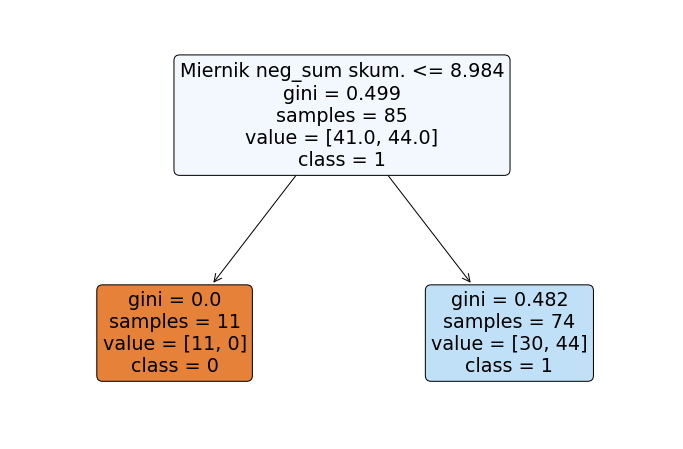

Accuracy: 0.6818181818181818
Balanced accuracy: 0.6818181818181818
Precision: 0.7291666666666667
Sensivity (recall): 0.6818181818181818
F1-Score: 0.6644880174291938


array([[ 5,  6],
       [ 1, 10]], dtype=int64)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df_mierniki_sum_klas[["Miernik neg_sum skum."]], df_mierniki_sum_klas["ZGON"], 
                                                    stratify=df_mierniki_sum_klas["ZGON"], test_size=odsetek, random_state=42)

# Utworzenie i dopasowanie modelu drzewa decyzyjnego
clf = DecisionTreeClassifier(random_state=42, max_depth=1)
clf.fit(X_train[["Miernik neg_sum skum."]], y_train.values.reshape(-1, 1))

# Przewidywanie na zbiorze testowym
y_pred = clf.predict(X_test[["Miernik neg_sum skum."]])

# Ocena dokładności
accuracy = accuracy_score(y_test, y_pred)

print(f'Dokładność klasyfikacji: {accuracy}')


plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=mierniki, class_names=['0', '1'], filled=True, rounded=True)
plt.show()

accuracy_assessment(y_test, y_pred)

confusion_matrix(y_test, y_pred)

#### Miernik sumujący wszystkie odchylenia od normy

Dokładność klasyfikacji: 0.5454545454545454


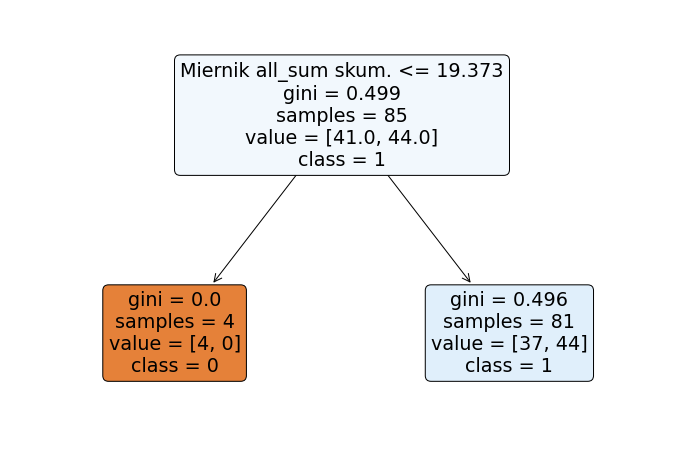

Accuracy: 0.5454545454545454
Balanced accuracy: 0.5454545454545454
Precision: 0.761904761904762
Sensivity (recall): 0.5454545454545454
F1-Score: 0.42708333333333337


array([[ 1, 10],
       [ 0, 11]], dtype=int64)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(df_mierniki_sum_klas[["Miernik all_sum skum."]], df_mierniki_sum_klas["ZGON"], 
                                                    stratify=df_mierniki_sum_klas["ZGON"],  test_size=odsetek, random_state=42)

# Utworzenie i dopasowanie modelu drzewa decyzyjnego
clf = DecisionTreeClassifier(random_state=42, max_depth=1)
clf.fit(X_train[["Miernik all_sum skum."]], y_train.values.reshape(-1, 1))

# Przewidywanie na zbiorze testowym
y_pred = clf.predict(X_test[["Miernik all_sum skum."]])

# Ocena dokładności
accuracy = accuracy_score(y_test, y_pred)
print(f'Dokładność klasyfikacji: {accuracy}')

plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=["Miernik all_sum skum."], class_names=['0', '1'], filled=True, rounded=True)
plt.show()
accuracy_assessment(y_test, y_pred)
confusion_matrix(y_test, y_pred)

#### Miernik na podstawie odchyleń świadczących o kwasicy z wagami PCA

In [89]:
X_train, X_test, y_train, y_test = train_test_split(df_miernik_last, df_miernik_last["ZGON"], 
                                                    stratify=df_miernik_last["ZGON"], test_size=odsetek, random_state=42)

X_data=X_train[col_neg].reset_index(drop=True)
y_data=y_train

pca_neg = PCA(n_components=1)
components = pca_neg.fit_transform(X_data)

kolumny_pca=col_neg

czynniki=pca_neg.components_
df_czynniki = pd.DataFrame(czynniki, columns=kolumny_pca)

def suma_iloczynow(wiersz):
    wagi = pca_neg.components_
    wartosci = wiersz[kolumny_pca].values
    return np.sum(wagi * wartosci)

df_miernik_df["Miernik neg PCA"]=df_miernik_df.apply(suma_iloczynow, axis=1)
df_miernik_df["Miernik neg PCA skum"]=df_miernik_df.groupby('PACJENT_NR')['Miernik neg PCA'].cumsum()
pca_neg.components_
pca_neg.explained_variance_ratio_

array([0.73044788])

#### Miernik na podstawie wszystkich odchyleń z wagami PCA

In [94]:
X_train, X_test, y_train, y_test = train_test_split(df_miernik_last, df_miernik_last["ZGON"], 
                                                    stratify=df_miernik_last["ZGON"], test_size=odsetek, random_state=42)

X_data=X_train[col_all].reset_index(drop=True)
y_data=y_train

pca_all = PCA(n_components=1)
components = pca_all.fit_transform(X_data)

kolumny_pca=col_all

czynniki=pca_all.components_
df_czynniki = pd.DataFrame(czynniki, columns=kolumny_pca)

def suma_iloczynow(wiersz):
    wagi = pca_all.components_
    wartosci = wiersz[kolumny_pca].values
    return np.sum(wagi * wartosci)

df_miernik_df["Miernik all PCA"]=df_miernik_df.apply(suma_iloczynow, axis=1)
df_miernik_df["Miernik all PCA skum"]=df_miernik_df.groupby('PACJENT_NR')['Miernik all PCA'].cumsum()

pca_all.components_
pca_all.explained_variance_ratio_

array([0.67549653])

In [96]:
df_miernik_last = df_miernik_df.groupby('PACJENT_NR').last()
df_miernik_last["PACJENT_NR"]=df_miernik_last.index
df_miernik_last=df_miernik_last.reset_index(drop=True)
mierniki_pca=["Miernik neg PCA skum", "Miernik all PCA skum"]
df_mierniki_sum_klas=df_miernik_last[[*mierniki_pca, "ZGON"]]

#### Klasyfikacja na podstawie ostatniej wartości mierników z wagami PCA

Dokładność klasyfikacji: 0.5909090909090909


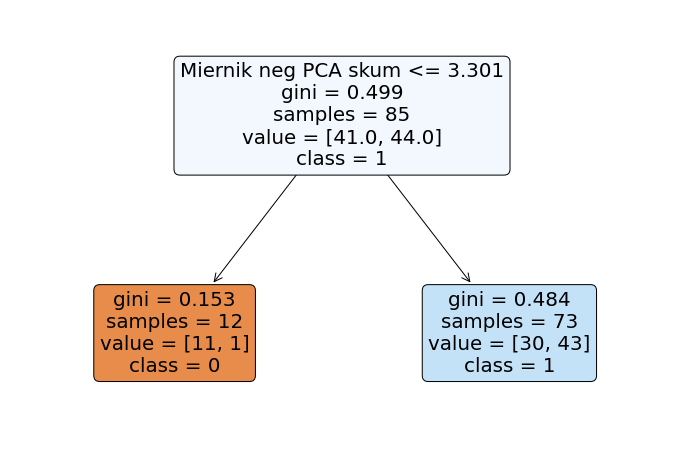

Accuracy: 0.5909090909090909
Balanced accuracy: 0.5909090909090908
Precision: 0.6527777777777778
Sensivity (recall): 0.5909090909090909
F1-Score: 0.5448275862068965


In [56]:
X_train, X_test, y_train, y_test = train_test_split(df_mierniki_sum_klas[mierniki_pca], df_mierniki_sum_klas["ZGON"], test_size=odsetek, 
                                                    stratify= df_mierniki_sum_klas["ZGON"], random_state=42)

# Utworzenie i dopasowanie modelu drzewa decyzyjnego
clf = DecisionTreeClassifier(random_state=42, max_depth=1)
clf.fit(X_train[["Miernik neg PCA skum"]], y_train.values.reshape(-1, 1))

# Przewidywanie na zbiorze testowym
y_pred = clf.predict(X_test[["Miernik neg PCA skum"]])

# Ocena dokładności
accuracy = accuracy_score(y_test, y_pred)
print(f'Dokładność klasyfikacji: {accuracy}')

plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=mierniki_pca, class_names=['0', '1'], filled=True, rounded=True)
plt.show()
accuracy_assessment(y_test, y_pred)

Dokładność klasyfikacji: 0.5454545454545454


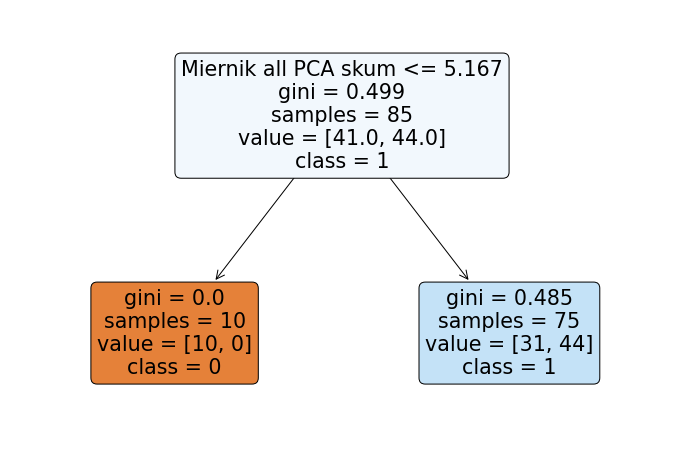

Accuracy: 0.5454545454545454
Balanced accuracy: 0.5454545454545454
Precision: 0.761904761904762
Sensivity (recall): 0.5454545454545454
F1-Score: 0.42708333333333337


In [57]:
X_train, X_test, y_train, y_test = train_test_split(df_mierniki_sum_klas[mierniki_pca], df_mierniki_sum_klas["ZGON"],  
                                                    stratify=df_mierniki_sum_klas["ZGON"], test_size=odsetek, random_state=42)

# Utworzenie i dopasowanie modelu drzewa decyzyjnego
clf = DecisionTreeClassifier(random_state=42, max_depth=1)
clf.fit(X_train[["Miernik all PCA skum"]], y_train.values.reshape(-1, 1))

# Przewidywanie na zbiorze testowym
y_pred = clf.predict(X_test[["Miernik all PCA skum"]])

# Ocena dokładności
accuracy = accuracy_score(y_test, y_pred)
print(f'Dokładność klasyfikacji: {accuracy}')

plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=["Miernik all PCA skum"], class_names=['0', '1'], filled=True, rounded=True)
plt.show()
accuracy_assessment(y_test, y_pred)


### Wizualizacja zmian miernika neg skum w czasie

In [61]:
# Podziel dane na dwie ramki danych
df_zgon_0 = df_miernik_df[df_miernik_df['ZGON'] == 0]
df_zgon_1 = df_miernik_df[df_miernik_df['ZGON'] == 1]

# fig0 = make_subplots(rows=1, cols=2, subplot_titles=['Zgon: nie', 'Zgon: tak'])
# Wykres dla ZGON=0
fig1 = px.line(df_zgon_0, x='BADANIE_NR', y='Miernik neg_sum skum.', color='PACJENT_NR', 
              labels={'BADANIE_NR': 'BADANIE_NR', 'Miernik neg_sum skum.': 'Miernik', 'PACJENT_NR': 'Pacjent'}, width=800, height=800)
fig1.update_xaxes(title_text='Numer badania')
fig1.update_yaxes(title_text='Miernik sumy negatywnych wyników')
fig1.update_layout(showlegend=False)

# Wykres dla ZGON=1
fig2 = px.line(df_zgon_1, x='BADANIE_NR', y='Miernik neg_sum skum.', color='PACJENT_NR', 
               labels={'BADANIE_NR': 'BADANIE_NR', 'Miernik neg_sum skum.': 'Miernik', 'PACJENT_NR': 'Pacjent'}, width=800, height=800)
fig2.update_xaxes(title_text='Numer badania')
fig2.update_yaxes(title_text='Miernik sumy negatywnych wyników')
fig2.update_layout(showlegend=False)

fig1.update_yaxes(range=[0, 180])
fig2.update_yaxes(range=[0, 180])

fig1.update_xaxes(range=[0, 65])
fig2.update_xaxes(range=[0, 65])

fig1.update_layout(
    xaxis=dict(
        tickfont=dict(size=18),
        title_font=dict(size=20),
    ),
    yaxis=dict(
        tickfont=dict(size=18),
        title_font=dict(size=20)
    )
)
fig2.update_layout(
    xaxis=dict(
        tickfont=dict(size=18),
        title_font=dict(size=24),
    ),
    yaxis=dict(
        tickfont=dict(size=18),
        title_font=dict(size=24)
    )
)
fig1.update_layout(template="plotly_white")
fig2.update_layout(template="plotly_white")
# Wyświetl oba wykresy
fig1.show()
fig2.show()
fig1.write_image("images4/"+"miernik_pacjenci_wyleczeni"+ ".png", width=1000, height=800, scale=4, format="png")
fig2.write_image("images4/"+"miernik_pacjenci_zmarli"+ ".png", width=1000, height=800, scale=4, format="png")
fig1.write_html("images4/miernik_pacjenci_wyleczeni.html")
fig2.write_html("images4/miernik_pacjenci_zmarli.html")
# fig0.write_html("ph_skumulowane.html")


### PCA na podstawie ostatnich wartości cols2=["BETET",	"CO2TET",	"O2TET", "IONH"]

In [98]:
X_train, X_test, y_train, y_test = train_test_split(df_miernik_last, df_miernik_last["ZGON"], 
                                                    stratify=df_miernik_last["ZGON"], test_size=odsetek, random_state=42)

X_data=X_train[cols2].reset_index(drop=True)
y_data=y_train

pca = PCA(n_components=2)
components = pca.fit_transform(X_data)

components_df = pd.DataFrame(components, columns=['Czynnik 1', 'Czynnik 2'])

train_data_reset_index = df_miernik_last.reset_index(drop=True)
components_df_reset_index = components_df.reset_index(drop=True)

merged_data = pd.concat([train_data_reset_index, components_df_reset_index], axis=1)
merged_data

pca.explained_variance_ratio_.sum()
pca.explained_variance_ratio_


array([0.56480056, 0.28938469])

In [99]:
merged_data['ZGON'] = merged_data['ZGON'].astype(str)

merged_data['Czy pacjent zmarł?'] = merged_data['ZGON'].map({'1.0': 'tak', '0.0': 'nie'})

fig = px.scatter(merged_data, x='Czynnik 1', y='Czynnik 2', color='Czy pacjent zmarł?', width=800, opacity=0.8) #text="PACJENT_NR")
fig.update_traces(textposition='top center', showlegend=True, marker_size=14) 

fig.update_layout(
    xaxis=dict(
        tickfont=dict(size=18),
        title_font=dict(size=20),
    ),
    yaxis=dict(
        tickfont=dict(size=18),
        title_font=dict(size=20)
    )
)
fig.update_layout(legend = dict(font = dict( size = 18)),
                  legend_title = dict(font = dict(size = 18)))
fig.update_layout(template="plotly_white")
fig.show()
fig.write_image("images4/"+"pca_miernik"+ ".png", width=1000, height=600, scale=4, format="png")


### PCA 3D na podsyawie ostatnich wartości negatywnych odchyleń

In [121]:
df_miernik

,BETET,CO2TET,O2TET,IONH,BETET_neg,O2TET_neg,IONH_neg,CO2TET_neg,BETET_all,O2TET_all,IONH_all,CO2TET_all,Miernik
0,0.326087,2.21,-0.720,1.882698,0.000000,0.72,0.882698,1.21,0.000000,0.72,0.882698,1.21,3.698785
1,0.086957,5.22,4.880,3.297125,0.000000,0.00,2.297125,4.22,0.000000,3.88,2.297125,4.22,13.484082
2,0.760870,3.10,6.000,2.201643,0.000000,0.00,1.201643,2.10,0.000000,5.00,1.201643,2.10,12.062512
3,0.869565,2.75,1.440,1.882698,0.000000,0.00,0.882698,1.75,0.000000,0.44,0.882698,1.75,6.942263
4,0.608696,2.61,2.800,1.970160,0.000000,0.00,0.970160,1.61,0.000000,1.80,0.970160,1.61,7.988855
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2929,-0.717391,1.63,0.420,2.294287,0.717391,0.00,1.294287,0.63,0.717391,0.00,1.294287,0.63,3.626896
2930,-0.891304,1.39,1.640,2.254399,0.891304,0.00,1.254399,0.39,0.891304,0.64,1.254399,0.39,4.393095
2931,-1.065217,1.71,0.316,2.708690,1.065217,0.00,1.708690,0.71,1.065217,0.00,1.708690,0.71,3.669473
2932,-0.695652,1.15,1.600,1.857967,0.695652,0.00,0.857967,0.15,0.695652,0.60,0.857967,0.15,3.912314


In [100]:
train_data, test_data = train_test_split(df_miernik_last, test_size=0.2, stratify=df_miernik_last["ZGON"], random_state=42)

X_train=train_data[col_neg].reset_index(drop=True)
y_train=train_data["ZGON"].reset_index(drop=True)

X_test=test_data[col_neg].reset_index(drop=True)
y_test=test_data["ZGON"].reset_index(drop=True)

pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train)

# model = RandomForestClassifier(random_state=42)
# model.fit(X_train_pca, y_train)
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_pca, y_train)
X_test_pca = pca.transform(X_test)
y_pred=lda.predict(X_test_pca)

# w = lda.coef_[0]
# b = lda.intercept_

# print(w)

# Przewidywanie na danych testowych po redukcji wymiarowości
# y_pred = model.predict(X_test_pca)

accuracy_assessment(y_pred, y_test)
pca.explained_variance_ratio_
# confusion_matrix(y_pred, y_test)
pca.components_

Accuracy: 0.8636363636363636
Balanced accuracy: 0.8928571428571428
Precision: 0.9008264462809918
Sensivity (recall): 0.8636363636363636
F1-Score: 0.8662200956937799


array([[ 0.10609772,  0.01654745,  0.77360133,  0.62450815],
       [ 0.51439963, -0.0598182 , -0.57822057,  0.6304568 ],
       [ 0.13711839,  0.98994907, -0.01464623, -0.03138269]])

In [ ]:
col_neg

['BETET_neg', 'O2TET_neg', 'CO2TET_neg', 'IONH_neg']

In [101]:
components_df2 = pd.DataFrame(X_train_pca, columns=['Czynnik 1', 'Czynnik 2', 'Czynnik 3'])

train_data_reset_index = train_data.reset_index(drop=True)
components_df_reset_index = components_df2.reset_index(drop=True)

merged_data = pd.concat([train_data_reset_index, components_df_reset_index], axis=1)
# merged_data

In [102]:
merged_data['ZGON'] = merged_data['ZGON'].astype(str)
merged_data['Czy pacjent zmarł?'] = merged_data['ZGON'].map({'1.0': 'tak', '0.0': 'nie'})

fig = px.scatter_3d(merged_data, x='Czynnik 1', y='Czynnik 2', z='Czynnik 3', color='Czy pacjent zmarł?', size_max=18, opacity=0.8)
fig.update_traces(textposition='top center', marker_size=6)

fig.update_layout(
    scene=dict(
        xaxis=dict(tickfont=dict(size=14)),
        yaxis=dict(tickfont=dict(size=14)),
        zaxis=dict(tickfont=dict(size=14)),
    )
)

fig.update_layout(legend=dict(font=dict(size=14)), legend_title=dict(font=dict(size=14)))
fig.update_layout(template="plotly_white")
fig.show()

fig.write_image("images4/" + "pca_miernik_3d" + ".png", width=1000, height=600, scale=4, format="png")
fig.write_html("pca_miernik_3d.html")

In [66]:
dane_pca3=merged_data[['Czynnik 1', 'Czynnik 2', 'Czynnik 3']]
dane_pca3

,Czynnik 1,Czynnik 2,Czynnik 3
0,-0.188120,-0.841056,-0.270277
1,0.096815,-0.914573,-0.353353
2,2.948894,-2.865586,1.061679
3,2.785068,2.238637,-0.206176
4,-0.785315,-0.390323,-0.350075
...,...,...,...
80,-1.334572,0.020214,-0.339676
81,-1.156313,-0.113974,-0.323246
82,-1.334572,0.020214,-0.339676
83,-1.257212,-0.037608,-0.341141


### LDA - klasyfikacja na podstawie ostatnich wartości ocdchyleń świadczących o kwasicy

In [67]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_pca, y_train)
X_test_pca = pca.transform(X_test)
y_pred=lda.predict(X_test_pca)

w = lda.coef_[0]
b = lda.intercept_

print(w)
accuracy_assessment(y_pred, y_test)

# comps=pd.DataFrame(components, columns=["Czynnik 1", "Czynnik 2"])
# comps["PACJENT_NR"]=train_data.index
# comps
# color_map = {1.0: 'red', 0.0: 'blue'}
# fig = px.scatter(comps, x='Czynnik 1', y='Czynnik 2', color=y_data, color_discrete_map=color_map, width=800)
# # # # # fig.write_image("images/pca.png")
# fig.show()


[0.54672764 0.25295341 0.20495296]
Accuracy: 0.8636363636363636
Balanced accuracy: 0.8928571428571428
Precision: 0.9008264462809918
Sensivity (recall): 0.8636363636363636
F1-Score: 0.8662200956937799


In [105]:
# def suma_iloczynow_wiersza(wiersz):
#     return np.sum(wiersz)#* wagi)

# df_miernik['Miernik'] = df_miernik[cols2].apply(suma_iloczynow_wiersza, axis=1)

In [107]:
# df_miernik_all=pd.DataFrame()
# df_miernik_all[["PACJENT_NR", "BADANIE_NR", "ZGON"]]=df_prep[["PACJENT_NR", "BADANIE_NR", "ZGON"]]
# df_miernik_all["Miernik"]=df_miernik["Miernik"]

C:\Users\dorot\AppData\Local\Temp\ipykernel_52004\1603519563.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



c:\Users\dorot\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_core.py:1006: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.

c:\Users\dorot\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_core.py:1006: FutureWarning:

When grouping 

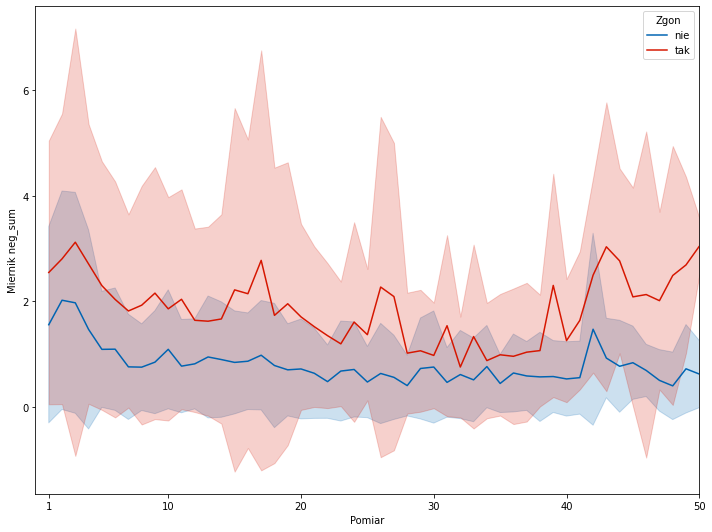

In [114]:
df_line = df_miernik_df.copy()
df_line["ZGON"].replace({0: "nie", 1: "tak"}, inplace=True)

plt.figure(figsize=(10, 7.5), facecolor='white')

sns.lineplot(data=df_line, x="BADANIE_NR", y='Miernik neg_sum', hue="ZGON", ci='sd',
                palette={'nie': my_blue, 'tak': my_red})

plt.xlabel('Pomiar')
plt.xlim(0, 50)
plt.xticks(ticks=[1, 10, 20, 30, 40, 50])
plt.legend(title="Zgon")
plt.tight_layout()

# Pokazywanie obrazu
plt.show()

### Klasyfikacja w czasie na podstawie ochyleń świadczących o kwasicy

In [115]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [116]:
results_df = pd.DataFrame(columns=['Badanie_NR',  'LDA', 'RandomForest','KNeighbors', 'SVC'])
merged_data=df_miernik_df[[*col_neg, "ZGON", "PACJENT_NR", "BADANIE_NR"]]


for i in range(2, 41):
    filtered_data = merged_data[merged_data['BADANIE_NR'] < i]
    X_data=filtered_data.groupby("PACJENT_NR").sum()[col_neg]
    y_data=filtered_data.groupby("PACJENT_NR")["ZGON"].first()

    # Przygotowanie danych do klasyfikacji
    X = X_data
    y = y_data

   # Klasyfikatory
    classifiers = {
        'LDA': LinearDiscriminantAnalysis(),
         'RandomForest': RandomForestClassifier(),
        'KNeighbors': KNeighborsClassifier(),
        'SVC': SVC()
    }

    # Pętla dla każdego klasyfikatora
    results = {'Badanie_NR': i}
    for clf_name, clf in classifiers.items():
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(clf, X, y, cv=skf, scoring='accuracy')
        mean_accuracy = scores.mean()
        results[clf_name] = mean_accuracy

    # Dodanie wyników do tymczasowej ramki danych
    temp_df = pd.DataFrame([results])

    # Konkatenacja wyników z ramką główną
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

results_df

C:\Users\dorot\AppData\Local\Temp\ipykernel_52004\1819610018.py:34: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,Badanie_NR,LDA,RandomForest,KNeighbors,SVC
0,2,0.542857,0.597835,0.681385,0.606926
1,3,0.541991,0.673160,0.625541,0.671429
2,4,0.551082,0.635931,0.569697,0.643723
3,5,0.598701,0.587446,0.624242,0.634632
4,6,0.570996,0.625541,0.578788,0.615584
5,7,0.589177,0.635498,0.579221,0.570996
6,8,0.644156,0.625541,0.597403,0.589177
7,9,0.671861,0.568831,0.541126,0.588312
8,10,0.652814,0.587013,0.578788,0.579221
9,11,0.635931,0.613853,0.505195,0.569697


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:

results_df = pd.DataFrame(columns=['Badanie_NR',  'LDA', 'DecisionTree', 'RandomForest', 'KNeighbors', 'SVC'])
merged_data = df_miernik_df[[*col_neg, "ZGON", "PACJENT_NR", "BADANIE_NR"]]

for i in range(2, 31):
    filtered_data = merged_data[merged_data['BADANIE_NR'] < i]
    
    # Grupowanie i sumowanie danych
    X_data = filtered_data.groupby("PACJENT_NR").sum()[col_neg]
    y_data = filtered_data.groupby("PACJENT_NR")["ZGON"].first()

        # Standaryzacja danych
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_data)

    # PCA
    pca = PCA(n_components=3)  # Ustaw liczbę komponentów zgodnie z wymaganiami
    X_pca = pca.fit_transform(X_scaled)

    # Przygotowanie danych do klasyfikacji
    X = X_pca
    y = y_data

    # Klasyfikatory
    classifiers = {
        'LDA': LinearDiscriminantAnalysis(),
        'DecisionTree': DecisionTreeClassifier(),
        'RandomForest': RandomForestClassifier(),
        'KNeighbors': KNeighborsClassifier(),
        'SVC': SVC()
    }

    # Pętla dla każdego klasyfikatora
    results = {'Badanie_NR': i-1}
    for clf_name, clf in classifiers.items():
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        scores = cross_val_score(clf, X, y, cv=skf, scoring='accuracy')
        mean_accuracy = scores.mean()
        results[clf_name] = mean_accuracy

    # Dodanie wyników do tymczasowej ramki danych
    temp_df = pd.DataFrame([results])

    # Konkatenacja wyników z ramką główną
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

results_df

C:\Users\dorot\AppData\Local\Temp\ipykernel_62548\532676112.py:44: FutureWarning:

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.



,Badanie_NR,LDA,DecisionTree,RandomForest,KNeighbors,SVC
0,1,0.624675,0.568831,0.652381,0.653247,0.680952
1,2,0.596537,0.641991,0.644156,0.596970,0.643723
2,3,0.615152,0.644589,0.634199,0.615152,0.606494
3,4,0.643723,0.522078,0.625974,0.559307,0.596537
4,5,0.653247,0.504762,0.549784,0.652814,0.670996
5,6,0.643290,0.578788,0.625541,0.577922,0.634632
6,7,0.670996,0.513420,0.540693,0.633333,0.634632
7,8,0.680952,0.589177,0.579654,0.615584,0.643290
8,9,0.671429,0.475325,0.570130,0.588312,0.633766
9,10,0.671861,0.635065,0.634632,0.597403,0.625541


In [ ]:
melted_results_df = pd.melt(results_df, id_vars=['Badanie_NR'], value_vars=['LDA', 'RandomForest', 'KNeighbors', 'SVC'],
                            var_name='Klasyfikator', value_name='Dokładność')
x_label='Numer badania'
title='klasyfikacja_obserwacje_accuracy'
# Tworzymy wykres
fig = px.line(melted_results_df, x='Badanie_NR', y='Dokładność', color='Klasyfikator', markers=True, line_shape='linear')

# Dodajemy etykiety i tytuł
fig.update_layout(
    xaxis=dict(
        title=x_label,
        tickfont=dict(size=16),
        title_font=dict(size=20),
    ),
    yaxis=dict(
        title='Dokładność',
        tickfont=dict(size=16),
        title_font=dict(size=20)
    )
)

fig.update_layout(template="plotly_white")
fig.show()
fig.write_image("images4/"+title+".png", width=1000, height=600, scale=4, format="png")
